# Dutch Corpora

In [1]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

# %pip install --upgrade pip  # Required for properly resolving dependencies
# %pip uninstall -y tempo_embeddings  # Remove existing installation
# %pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git
%pip install -e ../

Obtaining file:///Users/jose/Repos/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=8963 sha256=477db779d535dab14407d059016a3eca3ade0a3cef0195cc18c326b592e9d374
  Stored in directory: /private/var/folders/79/zf67ls7520x9m4mj7nx6q07w0000gp/T/pip-ephem-wheel-cache-rx8yzfn0/wheels/de/25/96/d92b7a130b730e0ab67770d76841f36cb3d1f9cda32a4a539b
Successfully built tempo_embeddings
  Attempting uninstall: tempo_embeddings
    Found existing installation: tempo_embeddings 0.0.1
    Uninstalling tempo_embeddings-0.0.1:
      Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
# make sure installation has succeeded
import tempo_embeddings

In [3]:
%load_ext autoreload

In [4]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Database

In [5]:
%autoreload now

from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from tempo_embeddings.embeddings.vector_database import ChromaDatabaseManager

MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
FILTER_TERMS = ["duurzaam"]

db = ChromaDatabaseManager(db_path="testing_db", embedder_name=MODEL_NAME, batch_size=10)
db.connect()

collection_name = "anp_sg_corpus"

anp_sg_corpus = Corpus.from_chroma_db(db, collection_name=collection_name, filter_terms=FILTER_TERMS)

Retrieved existing collection 'anp_sg_corpus'
): Voorzitter. De motie op stuk nr. 322 roept op tot het duurzaam en circulair aanleggen van kunstgrasvelden met rubberkorrels, maar kunstgrasvelden zijn niet duurzaam. De rubberkorrels belanden in het <class 'str'>
dit kabinet. Het is ongeloofwaardig naar mensen. Want wat zeg je hiermee? Dat een dode letter belangrijker is dan echt kijken hoe we mensen duurzaam uit de bijstand krijgen. Wat voor een signaal geef je <class 'str'>
heeft gesteld. Of het duurzaam is, is in dit geval aan de consument om te bepalen. We weten dat de consument meer en meer zekerheid wil hebben dat een en ander duurzaam geproduceerd is. De regeringen van <class 'str'>
wat er mogelijk is in dialoog met de VS. Mochten we daartoe kunnen komen, want we zijn er nog niet, dan willen we kijken wat dat pakket eventueel zou inhouden. We nemen daarbij alle aspecten mee, ook duurzaamheid <class 'str'>
gemaakte afspraken. Als ik de motie op die manier mag lezen, laat ik het oor

In [7]:
for p in anp_sg_corpus.passages[:20]:
    print(len(p), p)

corpus = anp_sg_corpus

print(corpus.embeddings.shape)

201 Passage('): Voorzitter. De motie op stuk nr. 322 roept op tot het duurzaam en circulair aanleggen van kunstgrasvelden met rubberkorrels, maar kunstgrasvelden zijn niet duurzaam. De rubberkorrels belanden in het', {'': '2331', 'RecId': 'h-tk-20182019-22-14', 'chamber': 'TweedeKamer', 'datapoint_x': 8.637298583984375, 'datapoint_y': 8.564299583435059, 'date': '2018-11-13', 'speakers': 'De voorzitter :|Mevrouw Teunissen ( PvdD ):|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :|De voorzitter :', 'title': 'handelingen', 'year': '2018'}, Highlighting(start=57, end=65))
202 Passage('dit kabinet. Het is ongeloofwaardig naar mensen. Want wat zeg je hiermee? Dat een dode letter belangrijker is dan echt kijken hoe we mensen duurzaam uit de bijstand krijgen. Wat voor een signaal geef je', {'': '1589', 'RecId': 'h-tk-20172018-2-8', 'chamber': 'TweedeKamer', 'datapoint_x': 5.463610649108887, 'datapoint_y': 8.763534545898438, 'date':

## Read Stopwords

In [8]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
zsh:1: command not found: wget


In [9]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [10]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(21, [0, 2, 106, 265, 303, 310, 356, 466, 484, 660]), Subcorpus(-1, [1, 3, 4, 19, 20, 26, 27, 28, 29, 33]), Subcorpus(10, [5, 16, 31, 628, 655, 874, 948, 956, 980, 996]), Subcorpus(16, [6, 24, 91, 112, 136, 162, 198, 212, 280, 286]), Subcorpus(25, [7, 77, 80, 100, 110, 117, 221, 226, 238, 239]), Subcorpus(27, [8, 14, 44, 48, 58, 65, 83, 97, 116, 118]), Subcorpus(8, [9, 10, 34, 38, 66, 67, 78, 101, 108, 139]), Subcorpus(18, [11, 39, 41, 51, 55, 74, 155, 158, 256, 259]), Subcorpus(30, [12, 15, 151, 452, 623, 694, 760, 765, 787, 833]), Subcorpus(19, [13, 81, 89, 215, 308, 354, 420, 486, 590, 645]), Subcorpus(0, [17, 22, 25, 53, 76, 85, 124, 148, 153, 157]), Subcorpus(9, [18, 30, 37, 43, 419, 424, 487, 496, 513, 517]), Subcorpus(15, [21, 189, 492, 532, 600, 617, 716, 752, 773, 779]), Subcorpus(2, [23, 107, 156, 163, 176, 284, 351, 357, 380, 421]), Subcorpus(6, [32, 173, 182, 261, 270, 440, 442, 493, 575, 592]), Subcorpus(17, [36, 45, 54, 236, 326, 342, 473, 482, 519, 520]), Subco

In [11]:
for cluster in clusters:
    cluster.set_topic_label(exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5)
    print(cluster)

Subcorpus('glb; koppelen; duurzaamheid; gebied; streefdoelen', [0, 2, 106, 265, 303, 310, 356, 466, 484, 660])
Subcorpus('Outliers', [1, 3, 4, 19, 20, 26, 27, 28, 29, 33])
Subcorpus('luchtvaart; steken; plenair; innovaties; plan', [5, 16, 31, 628, 655, 874, 948, 956, 980, 996])
Subcorpus('duurzaamheid; economie; onderwijs; vak; vorming', [6, 24, 91, 112, 136, 162, 198, 212, 280, 286])
Subcorpus('inkopen; motie; groningen; energierekening; heel', [7, 77, 80, 100, 110, 117, 221, 226, 238, 239])
Subcorpus('duurzaamheid; partij; dank; cda; vvd', [8, 14, 44, 48, 58, 65, 83, 97, 116, 118])
Subcorpus('nederland; monitor; nederlandse; duurzaamheid; kabinet', [9, 10, 34, 38, 66, 67, 78, 101, 108, 139])
Subcorpus('verduurzaamd; woningen; corporaties; gebouwd; huurders', [11, 39, 41, 51, 55, 74, 155, 158, 256, 259])
Subcorpus('geld; duurzaamheid; hadden; waar; zeggen', [12, 15, 151, 452, 623, 694, 760, 765, 787, 833])
Subcorpus('werk; mensen; participatiewet; inkomen; arbeidsvermogen', [13, 81, 8

/Users/jose/Repos/tempo-embeddings/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [12]:
with open("clusters.txt", "wt") as f:
    for cluster in clusters:
        print(
            ", ".join(
                cluster.top_words(
                    exclude_words=frozenset(stopwords | set(FILTER_TERMS)), n=5
                )
            ),
            file=f,
        )

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

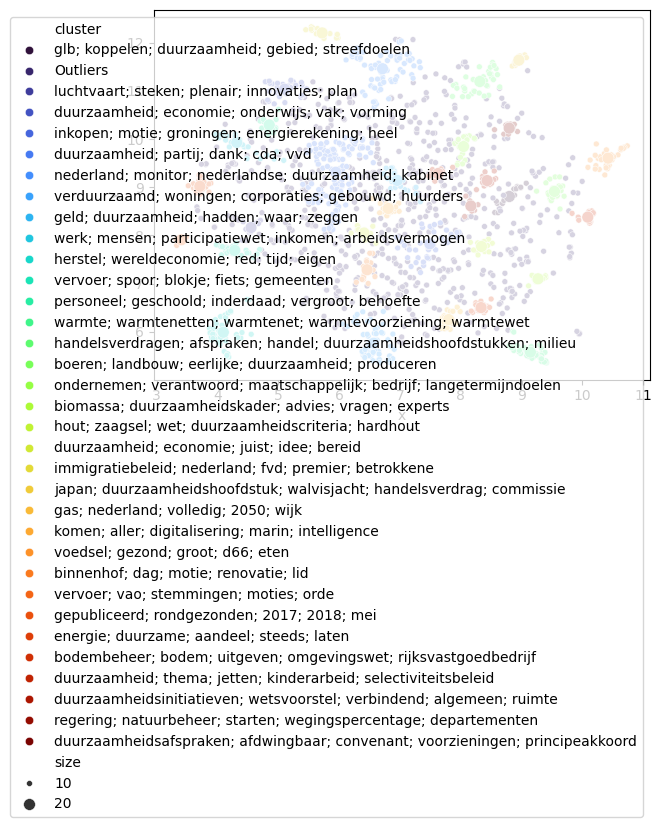

In [13]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [14]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "*"

show(visualizer.create_document)

Loading BokehJS ...